<a href="https://colab.research.google.com/github/OYAMAKOSEN-ProconProject/dcon2023_dl_cl/blob/noisy/DconDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コラボワーク２（2週目資料）

## 画像分類を実行する前に学習用データを準備する

### **1. ２種類の分類対象（AとB）をそれぞれ別フォルダ（aとb）に保存する**

### 2. Google colaboratoryにデータをアップロードする
※アップロードする際にフォルダを準備する必要がある。


参考：https://github.com/miyamotok0105/pytorch_handbook

（ライセンス：https://github.com/miyamotok0105/pytorch_handbook/blob/master/LICENSE.md）

写真データをアップロードするフォルダを作成します。
dataフォルダを作成し、その中に「a」と「b」のフォルダを作成します。

In [68]:
!pip install rembg
import os
import shutil

if os.path.isdir("./data"):
  shutil.rmtree("./data")

os.mkdir("./data")
os.mkdir("./data/a")
os.mkdir("./data/b")


os.mkdir("./remove")
os.mkdir("./remove/a")
os.mkdir("./remove/b")

RemBGを実行します

In [69]:
from rembg import remove
from PIL import Image
import numpy as np
import cv2

import os

# 指定されたディレクトリ
base_directory = "remove"
# ファイルのパスを格納するリスト
file_paths = []

# os.walk()を使用してディレクトリ内のファイルのパスを取得
for foldername, subfolders, filenames in os.walk(base_directory):
    for filename in filenames:
        file_path = os.path.join(foldername, filename)
        file_paths.append("./"+file_path)

# 結果のリストを表示
print(file_paths)

mu = 0
sigma = 50

for rmfile in file_paths:
  input_path = rmfile
  output_path = input_path.replace("remove","data",).replace(".jpg","")
  print(rmfile)


  input = cv2.imread(input_path)
  vanilla = Image.fromarray(input)

  # 同サイズのガウシアンノイズを作成
  noise = np.random.normal(mu, sigma, input.shape)
  # ノイズを付加して8bitの範囲にクリップ
  noise = input.astype(np.float64) + noise
  noise = np.clip(noise, 0, 255).astype(np.uint8)
  # 行列を画像に変換
  noised_img = Image.fromarray(noise)
  trim_img = remove(noised_img)

  # output = noised_img

  noised_img.save(output_path+"n"+".png",'PNG')
  trim_img.save(output_path+"t"+".png",'PNG')
  vanilla.save(output_path+".png",'PNG')

['./remove/b/000248.jpg', './remove/b/000548.jpg', './remove/b/000210.jpg', './remove/b/000381.jpg', './remove/b/000113.jpg', './remove/b/000147.jpg', './remove/b/000205.jpg', './remove/b/000283.jpg', './remove/b/000340.jpg', './remove/b/000129.jpg', './remove/b/000130.jpg', './remove/b/000272.jpg', './remove/b/000126.jpg', './remove/b/000376.jpg', './remove/b/000475.jpg', './remove/b/000015.jpg', './remove/b/000004.jpg', './remove/b/000287.jpg', './remove/b/000105.jpg', './remove/b/000221.jpg', './remove/b/000465.jpg', './remove/b/000022.jpg', './remove/b/000094.jpg', './remove/a/000028.jpg', './remove/a/000199.jpg', './remove/a/000196.jpg', './remove/a/000210.jpg', './remove/a/000536.jpg', './remove/a/000113.jpg', './remove/a/000620.jpg', './remove/a/000517.jpg', './remove/a/000373.jpg', './remove/a/000629.jpg', './remove/a/000632.jpg', './remove/a/000338.jpg', './remove/a/000645.jpg', './remove/a/000116.jpg', './remove/a/000032.jpg', './remove/a/000316.jpg', './remove/a/000549.jpg',

dataフォルダの中のフォルダ「a」にAの写真、フォルダ「b」にBの写真を保存します。

In [70]:
import os
import shutil

if os.path.isdir("./train"):
  shutil.rmtree("./train")
os.mkdir("./train")
os.mkdir("./train/a")
os.mkdir("./train/b")

if os.path.isdir("./val"):
  shutil.rmtree("./val")
os.mkdir("./val")
os.mkdir("./val/a")
os.mkdir("./val/b")

img_root ='data'
data_root ='./'
img_a_path = os.path.join(img_root, 'a')
img_b_path = os.path.join(img_root, 'b')

train_a_path = os.path.join(data_root, 'train', 'a')
train_b_path = os.path.join(data_root, 'train', 'b')
val_a_path = os.path.join(data_root, 'val', 'a')
val_b_path = os.path.join(data_root, 'val', 'b')

a_images = os.listdir(img_a_path)
b_images = os.listdir(img_b_path)

for i in range(len(a_images)):
    if i< 0.7*len(a_images):
        shutil.copy(os.path.join(img_a_path,a_images[i]),train_a_path)
    else:
        shutil.copy(os.path.join(img_a_path,a_images[i]),val_a_path)

for i in range(len(b_images)):
    if i< 0.7*len(b_images):
        shutil.copy(os.path.join(img_b_path,b_images[i]),train_b_path)
    else:
        shutil.copy(os.path.join(img_b_path,b_images[i]),val_b_path)

# 学習プログラムの実行

In [71]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
%matplotlib inline
import time
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt

In [72]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [73]:
#画像の前処理
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
#正規化をしない前処理
to_tensor_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

In [74]:
root = data_root#'test'

class CustomDataset(torch.utils.data.Dataset):
    classes = ['a', 'b']

    def __init__(self, root, transform=None, train=True):
        # 指定する場合は前処理クラスを受け取ります。
        self.transform = transform
        # 画像とラベルの一覧を保持するリスト
        self.images = []
        self.labels = []

        # 訓練の場合と検証の場合でフォルダわけ
        # 画像を読み込むファイルパスを取得します。
        if train == True:
            root_a_path = os.path.join(root, 'train', 'a')
            root_b_path = os.path.join(root, 'train', 'b')
        else:
            root_a_path = os.path.join(root, 'val', 'a')
            root_b_path = os.path.join(root, 'val', 'b')
        # Aの画像一覧を取得します。
        a_images = os.listdir(root_a_path)
        # ここではAをラベル０に指定します。
        a_labels = [0] * len(a_images)
        # Bの画像一覧を取得します。
        b_images = os.listdir(root_b_path)
        # ここではBをラベル１に指定します。
        b_labels = [1] * len(b_images)
        # 1個のリストにします。
        for image, label in zip(a_images, a_labels):
            self.images.append(os.path.join(root_a_path, image))
            self.labels.append(label)
        for image, label in zip(b_images, b_labels):
            self.images.append(os.path.join(root_b_path, image))
            self.labels.append(label)

    def __getitem__(self, index):
        # インデックスを元に画像のファイルパスとラベルを取得します。
        image = self.images[index]
        label = self.labels[index]
        # 画像ファイルパスから画像を読み込みます。
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        # 前処理がある場合は前処理をいれます。
        if self.transform is not None:
            image = self.transform(image)
        # 画像とラベルのペアを返却します。
        return image, label

    def __len__(self):
        # ここにはデータ数を指定します。
        return len(self.images)

### 人工知能を訓練するためのデータの確認

ラベルを表示：「0」はAのモノ、「1]はBのモノを表しています
[0 1 1 1 1 0 0]


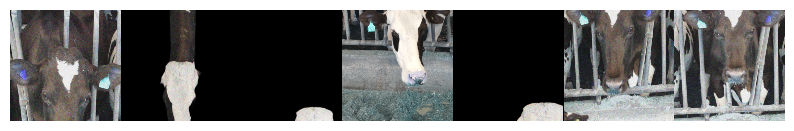

In [75]:
# 訓練データのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms, train=True)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=7,
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print("ラベルを表示：「0」はAのモノ、「1]はBのモノを表しています")

    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')

    break

[1 1 0 1 1 1 1]


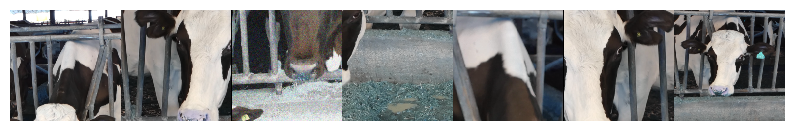

In [76]:
# テストデータのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=7,
                                           shuffle=True)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

for i, (images, labels) in enumerate(custom_loader):
    print(labels.numpy())
    show(torchvision.utils.make_grid(images, padding=1))
    plt.axis('off')

    break

# 学習を実行する準備をします

In [77]:
custom_train_dataset = CustomDataset(root, data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=custom_train_dataset,
                                           batch_size=5,
                                           shuffle=True)
custom_test_dataset = CustomDataset(root, data_transforms["val"])
test_loader = torch.utils.data.DataLoader(dataset=custom_test_dataset,
                                           batch_size=5,
                                           shuffle=False)

In [78]:
#ネットワークalexnetの定義
net = models.alexnet(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [79]:
#ネットワークのパラメータを凍結
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)

In [80]:
#最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 人工知能の学習を実行します！

In [81]:
from tqdm import tqdm

In [82]:
num_epochs = 15

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in tqdm(range(num_epochs), desc="学習中", postfix="range", ncols=80):
#for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

#    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}'
#                      .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

学習中: 100%|████████████████████████████| 15/15 [03:12<00:00, 12.81s/it, range]


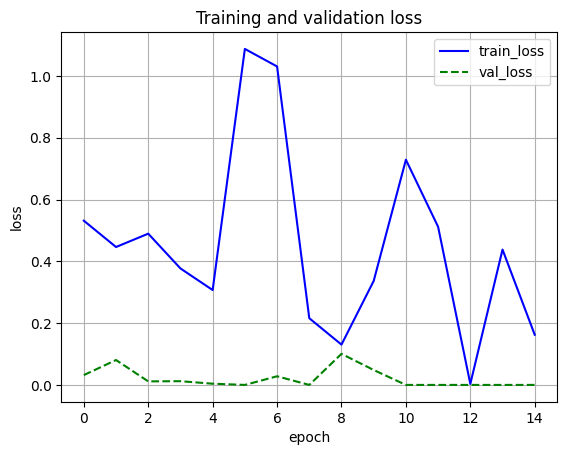

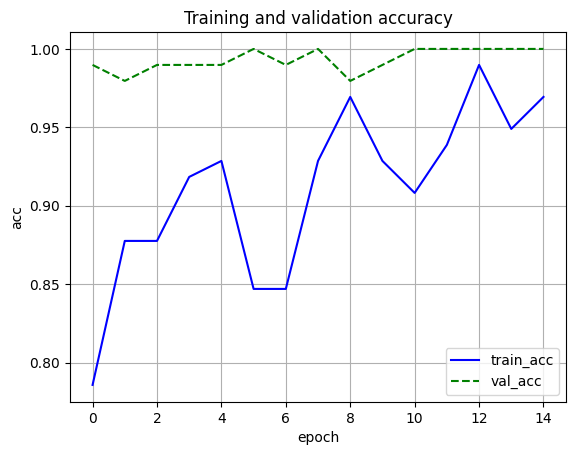

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

# 学習結果の評価

上手に人工知能が画像を判断できているかのチェック

正解:
[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]
推論（人工知能が予測した）結果:
[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
0.8666666666666667


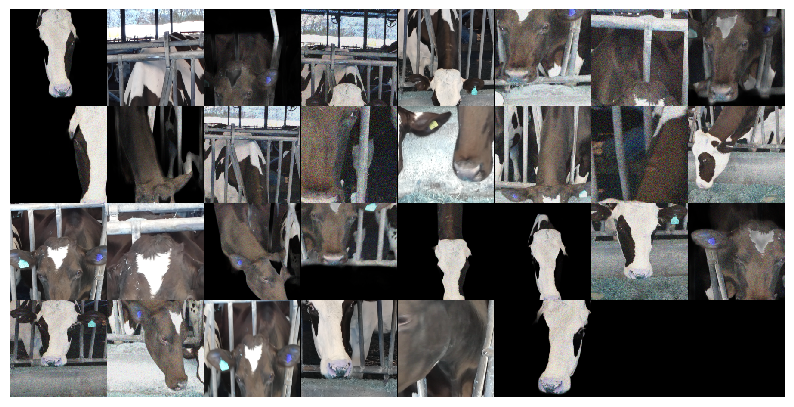

In [84]:
net.eval()

# テストデータのプロット
custom_dataset = CustomDataset(root, to_tensor_transforms)
custom_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=30,
                                           shuffle=True)

def show(img):
    npimg = img.detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# 正解と推論の初期化
ans_list = []
ext_list = []

# 予測結果と正解を取得
for i, (images, labels) in enumerate(custom_loader):
    images = images.to(device)
    outputs = net(images)
    ans_list.extend(labels.numpy())
    ext_list.extend(outputs.max(1)[1].cpu().numpy())

    if i == 0:
        # 1バッチ分だけ表示
        print('正解:')
        print(ans_list)
        print('推論（人工知能が予測した）結果:')
        print(ext_list)
        show(torchvision.utils.make_grid(images, padding=1))
        plt.axis('off')
        break

# 正解数の計算
correct_count = sum([1 for ans, ext in zip(ans_list, ext_list) if ans == ext])
accuracy = correct_count / len(ans_list)
print(accuracy)
